### Objective of the study

### IMPORT LIBRARIES


- Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many water points already established in the country, but some are in need of repair while others have failed altogether.

- Build a classifier to predict the condition of a water well, using information about the sort of pump, when it was installed, etc. Your audience could be an NGO focused on locating wells needing repair, or the Government of Tanzania looking to find patterns in non-functional wells to influence how new wells are built. Note that this is a ternary classification problem by default, but can be engineered to be binary.

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### 1.1 Read the Dataset 

In [98]:
df = pd.read_csv("d.3.csv")
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [99]:
df.shape

(59400, 40)

In [100]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [101]:
df1 = pd.read_csv("d.1.csv")
df1.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [102]:
# Default merge (inner join)
merged_df = df.merge(df1, on='id')
print(merged_df.shape)

(59400, 41)


In [103]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [104]:
merged_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


### 1.2 Dealing with missing Values


In [105]:
# checking missing values
merged_df.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

our dataset contains missing values on the following columns; public_meeting, subvillage,scheme_management,scheme_name, permit,funder, and  installer.
From the above we drop irrevelant columns with missing values since they are of no use to us on the study which includes; subvillage,public_meeting and scheme_name

In [106]:
# code that drops the three columns 
merged_df.drop(['subvillage', 'scheme_name','public_meeting'], axis=1, inplace=True)

In [107]:
# checking % of missing values 
missing_value_columns = ['installer', 'funder', 'scheme_management', 'permit']
for col in missing_value_columns:
    print("Percent of missing values in {} column: {:.2%}".format(col, merged_df[col].isna().sum() / len(merged_df)))


Percent of missing values in installer column: 6.15%
Percent of missing values in funder column: 6.12%
Percent of missing values in scheme_management column: 6.53%
Percent of missing values in permit column: 5.14%


In [108]:
# Filling missing values with mode for each column
for col in missing_value_columns:
    mode_value = merged_df[col].mode()[0]  # Calculate the mode (most frequent value) for the column
    merged_df[col].fillna(mode_value, inplace=True)  # Fill missing values with the mode
    
# Check if missing values are filled
for col in missing_value_columns:
    print("Percent of missing values in {} column after filling: {:.2%}".format(col, merged_df[col].isna().sum() / len(df)))


Percent of missing values in installer column after filling: 0.00%
Percent of missing values in funder column after filling: 0.00%
Percent of missing values in scheme_management column after filling: 0.00%
Percent of missing values in permit column after filling: 0.00%


In [109]:
# rechecking missing values
merged_df.isna().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
s

### 1.3 Dropping Irrelevant Columns 

- date_recorded >since there is a contruction year, this is not needed to make a prediction on well functionality.
- funder > 11,307 rows have matching values with installer column, and many more rows only have different spellings of the same entry. The installer has a higher influence on the functionality of a well and I will therefore, drop the funder column to avoid multicollinearity effect.
- wpt_name > too many unique values
- subvillage > it can be represented by the region
- lga > it can be represented by the region
- ward > it can be represented by the region
- recorded_by > it has the same value for all rows
- scheme_name > too many unique values and nulls
- extraction_type > too similar to extraction type class
- extraction_type_group > too similar to extraction type class
- management > management_group are categories of management so I will drop manageme
- payment > payment and payment_type are duplicates, so I will drop payment
- quality_group > correlated with water quality. I'll retain water quality since it has unique rows that need to be dropped
- quantity > quantity_group are categories of quantity, so I will drop quantity.
- source > it can be represented by source class.
- source_type > it can be represented by source class.
- waterpoint_type > it is a duplicate of waterpoint_type_group.
- num_private > no description has been given for this column and close to 99% are 0 values; this is likely not useful for modelling.
- region_code > a duplicate of region.
- district_code > it can be represented by the region.

In [110]:
columns_to_drop = ['date_recorded', 'funder', 'wpt_name','lga', 
 'ward', 'recorded_by', 'extraction_type', 
 'extraction_type_group', 'management', 'payment', 'quality_group', 
 'quantity', 'source', 'source_type', 'waterpoint_type', 'num_private', 
 'region_code', 'district_code']

# Drop the columns from dataset
df = merged_df.drop(columns_to_drop, axis=1)

In [111]:
df.shape


(59400, 20)

In [112]:
df.columns

Index(['id', 'amount_tsh', 'gps_height', 'installer', 'longitude', 'latitude',
       'basin', 'region', 'population', 'scheme_management', 'permit',
       'construction_year', 'extraction_type_class', 'management_group',
       'payment_type', 'water_quality', 'quantity_group', 'source_class',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [113]:
print (df['construction_year'])

0        1999
1        2010
2        2009
3        1986
4           0
         ... 
59395    1999
59396    1996
59397       0
59398       0
59399    2002
Name: construction_year, Length: 59400, dtype: int64


In [114]:
df['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [115]:
df['construction_year'].replace(to_replace = 0, value = 1966, inplace=True)

Replaced 0 construction year with 1966 as a placeholder.

### 2.1 Grouping columns Related Columns

scheme_management / management / management_group columns

Since our data are kinda related we opted to group some columns for clear viasulization 

#### source, source_class and source_type column

### visualing Categorical variables

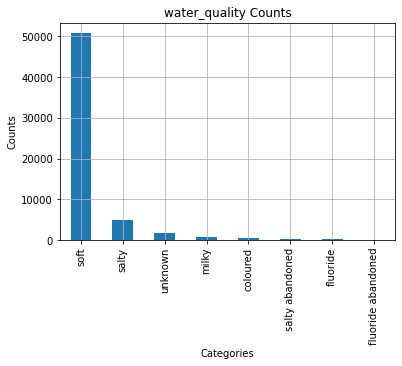

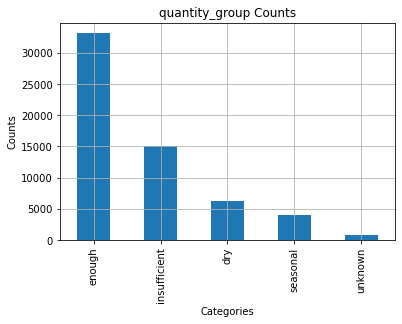

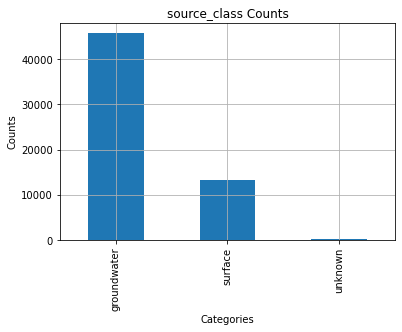

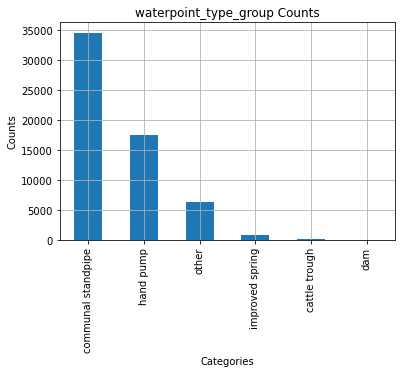

In [116]:
import matplotlib.pyplot as plt

# List of columns to be combined for plotting
quality_combined = ['water_quality', 'quantity_group', 'source_class',
                     'waterpoint_type_group']

# Iterate over each column in the list
for col in quality_combined:
    merged_df[col].value_counts().plot(kind='bar')
    plt.title(col + ' Counts')
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.grid()
    plt.show()


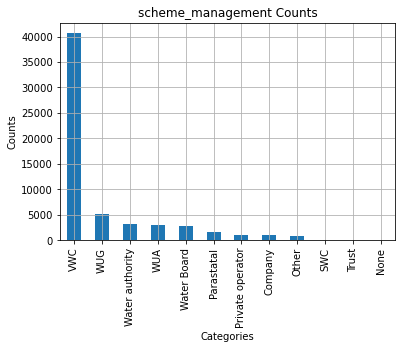

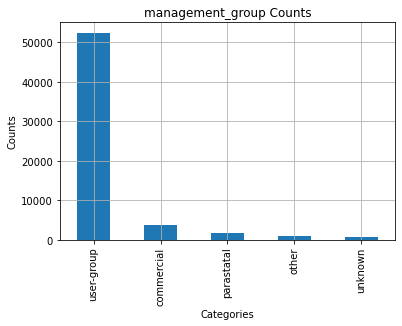

In [117]:
import matplotlib.pyplot as plt

# List of columns to be combined for plotting
management_combined = ['scheme_management','management_group']

# Iterate over each column in the list
for col in management_combined:
    df[col].value_counts().plot(kind='bar')
    plt.title(col + ' Counts')
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.grid()
    plt.show()

c:\Users\User\anaconda3\ana\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


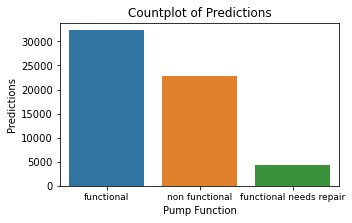

In [118]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.countplot(df['status_group'])
x_labels = df['status_group'].unique()


plt.title('Countplot of Predictions')
plt.xlabel('Pump Function')
ax.set_xticklabels(x_labels, fontsize=9)
plt.ylabel('Predictions')
plt.show()

We notice that the target classes are imbalanced, with the functional pumps being the most common at more than 30,000 followed by non-functional pumps at above 20,000 pumps, and then lastly the functional-need-repair pumps at less than 5,000.

### Visualizing continuous variables


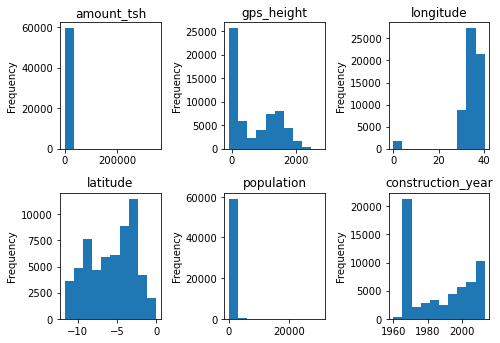

In [119]:
import matplotlib.pyplot as plt

continuous = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']
fig = plt.figure(figsize=(7, 7))
for i, col in enumerate(continuous):
    ax = plt.subplot(3, 3, i + 1)
    df[col].plot(kind='hist', ax=ax, title=col)
plt.tight_layout()
plt.show()

From the above, we notice that no continous variable is normally distributed.

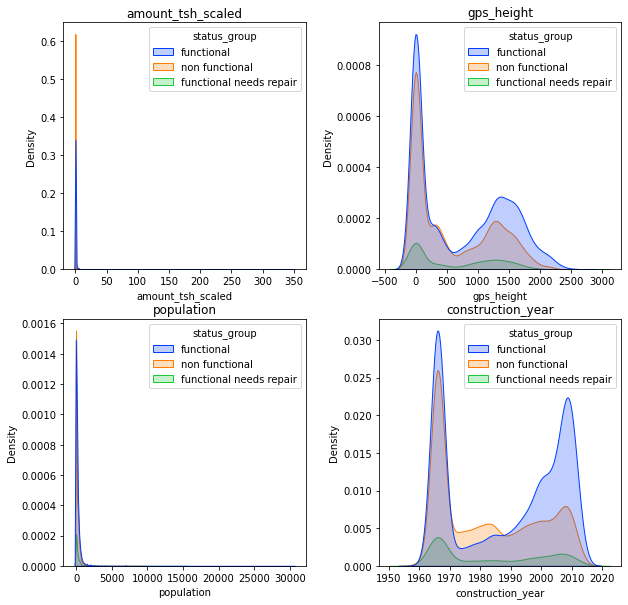

In [120]:
# Set up the subplots with 2 columns and increased spacing
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.3)  # Increase hspace and wspace

# Scale the amount column by dividing by 10,000
df['amount_tsh_scaled'] = df['amount_tsh'] / 1000
# Create KDE plots for continuous variables
continuous = ['amount_tsh_scaled', 'gps_height', 'population', 'construction_year']

for i, column in enumerate(continuous):
    row, col = i // 2, i % 2
    sns.kdeplot(data=df, x=column, hue='status_group', palette='bright', fill=True, ax=axes[row, col])
    axes[row, col].set_title(column)

plt.show()

1. Among pump types non-functional ones are the most common followed by functional and then functional need repair

2. At sea level functional and non-functional pumps are similar but very few need repair

3. Areas with no population have the most pumps overall

4. It is Plausible that many pump were built in  between the year 1960-1970
also newer pumps tend to be functional while older ones are more likely to be non-functional

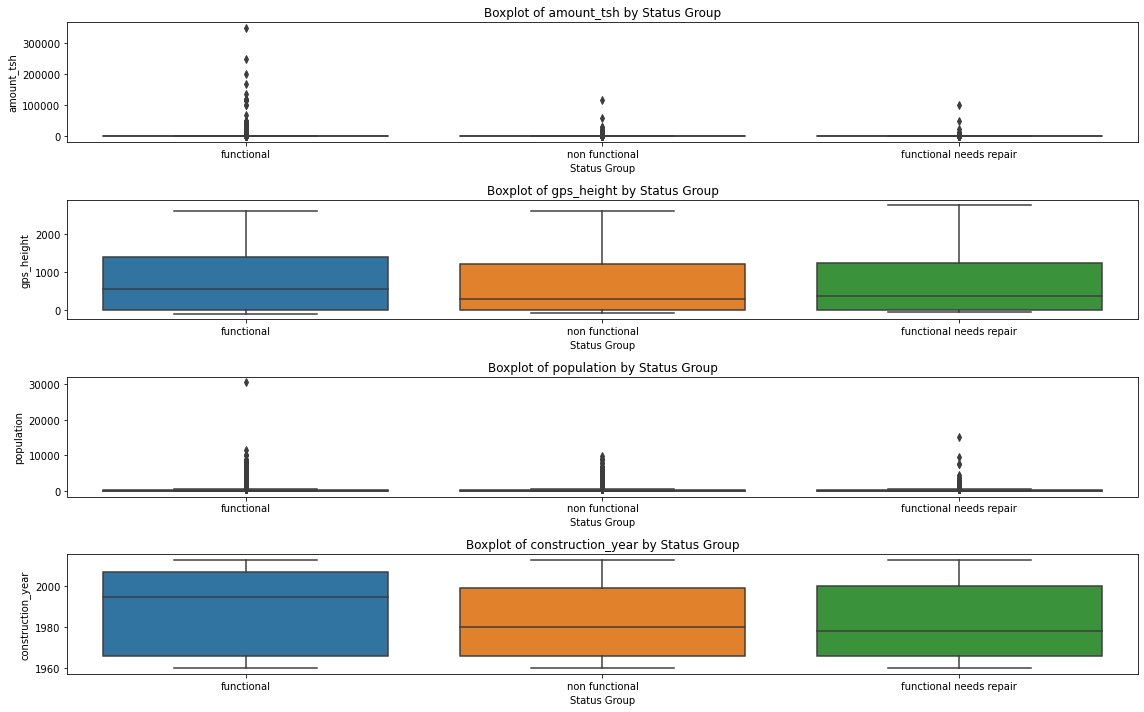

In [121]:
# Define the columns to include in the box plots
columns_to_plot = ['amount_tsh', 'gps_height', 'population', 'construction_year']

# Set up the subplots
fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize = (16, 10))

# Loop through each column and create a box plot
for i, column in enumerate(columns_to_plot):
    sns.boxplot(x='status_group', y=column, data=df, ax=axes[i])
    axes[i].set_ylabel(column)  # Set the y-axis label for each subplot
    axes[i].set_xlabel('Status Group')  # Set the x-axis label for each subplot
    axes[i].set_title(f'Boxplot of {column} by Status Group')  # Set the title for each subplot

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

*Conclusion*
- There is significant difference in functional pumps compared to non functional and those that need repair when we compare against population, amount and gps height.
- on gps comparison pumps that need repair outdo those that not functional
- constration year has no signifacance on the pump status, the distribution is more of the same 
- construction year does not have a significant on the status_group
- Interestingly, most pumps that needs repair are affected by gps heights

In [122]:
df.corr

<bound method DataFrame.corr of           id  amount_tsh  gps_height     installer  longitude   latitude  \
0      69572      6000.0        1390         Roman  34.938093  -9.856322   
1       8776         0.0        1399       GRUMETI  34.698766  -2.147466   
2      34310        25.0         686  World vision  37.460664  -3.821329   
3      67743         0.0         263        UNICEF  38.486161 -11.155298   
4      19728         0.0           0       Artisan  31.130847  -1.825359   
...      ...         ...         ...           ...        ...        ...   
59395  60739        10.0        1210           CES  37.169807  -3.253847   
59396  27263      4700.0        1212          Cefa  35.249991  -9.070629   
59397  37057         0.0           0           DWE  34.017087  -8.750434   
59398  31282         0.0           0          Musa  35.861315  -6.378573   
59399  26348         0.0         191         World  38.104048  -6.747464   

                         basin       region  population

### CORRELATION 

<AxesSubplot:>

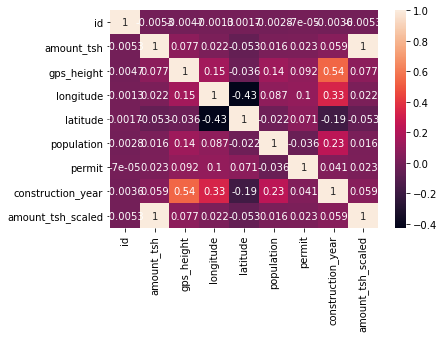

In [123]:
sns.heatmap(df.corr(),annot=True)

There is a significant correlation between construction year and gps_height which gives us the highest correlation of 0.54. Also we note that there is a slight correlation between population and construction year.

Waterwells that need repair are consider them non-functioning because the population is not relaying on them for water.
Therefore we perform future engineering and combine non-functioning and functioning need repair.

### converting categorical data into numbers

In [124]:
# Map 'functional' to 0, and 'non functional'/'functional needs repair' to 1
df['target'] = df['status_group'].map({'functional': 1, 'non functional': 0, 'functional needs repair': 0})

# Drop the original 'status_group' column if not needed anymore
df.drop('status_group', axis=1, inplace=True) 
# Now, 'target' column contains the combined information

### 1. SPLITTING AND TRAINING DATA INTO FEATURE (X) AND TARGET (Y) DATASETS

In [125]:
# imports for preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer



In [126]:
y = df['target']
X = df.drop('target', axis=1)

# Print first 5 rows of X
X.head()

,id,amount_tsh,gps_height,installer,longitude,latitude,basin,region,population,scheme_management,permit,construction_year,extraction_type_class,management_group,payment_type,water_quality,quantity_group,source_class,waterpoint_type_group,amount_tsh_scaled
0,69572,6000.0,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,109,VWC,False,1999,gravity,user-group,annually,soft,enough,groundwater,communal standpipe,6.000
1,8776,0.0,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,280,Other,True,2010,gravity,user-group,never pay,soft,insufficient,surface,communal standpipe,0.000
2,34310,25.0,686,World vision,37.460664,-3.821329,Pangani,Manyara,250,VWC,True,2009,gravity,user-group,per bucket,soft,enough,surface,communal standpipe,0.025
3,67743,0.0,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,58,VWC,True,1986,submersible,user-group,never pay,soft,dry,groundwater,communal standpipe,0.000
4,19728,0.0,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,0,VWC,True,1966,gravity,other,never pay,soft,seasonal,surface,communal standpipe,0.000


ONE-HOT ENCODING OF CATEGORICAL FEATURES

In [127]:
cat_col = ['installer', 'basin', 'region', 'scheme_management', 
           'extraction_type_class', 'management_group', 'payment_type', 
           'water_quality', 'quantity_group', 'source_class', 
           'waterpoint_type_group']

cont_col = ['amount_tsh','gps_height','longitude','latitude','population','construction_year']

binary_col = ['public_meeting', 'permit']

In [128]:
#Create dummies
X = pd.get_dummies(X, columns=cat_col)

# Print X
X

,id,amount_tsh,gps_height,longitude,latitude,population,permit,construction_year,amount_tsh_scaled,installer_-,...,quantity_group_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,69572,6000.0,1390,34.938093,-9.856322,109,False,1999,6.000,0,...,0,1,0,0,0,1,0,0,0,0
1,8776,0.0,1399,34.698766,-2.147466,280,True,2010,0.000,0,...,0,0,1,0,0,1,0,0,0,0
2,34310,25.0,686,37.460664,-3.821329,250,True,2009,0.025,0,...,0,0,1,0,0,1,0,0,0,0
3,67743,0.0,263,38.486161,-11.155298,58,True,1986,0.000,0,...,0,1,0,0,0,1,0,0,0,0
4,19728,0.0,0,31.130847,-1.825359,0,True,1966,0.000,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,1210,37.169807,-3.253847,125,True,1999,0.010,0,...,0,1,0,0,0,1,0,0,0,0
59396,27263,4700.0,1212,35.249991,-9.070629,56,True,1996,4.700,0,...,0,0,1,0,0,1,0,0,0,0
59397,37057,0.0,0,34.017087,-8.750434,0,False,1966,0.000,0,...,0,1,0,0,0,0,0,1,0,0
59398,31282,0.0,0,35.861315,-6.378573,0,True,1966,0.000,0,...,0,1,0,0,0,0,0,1,0,0


MACHINE LEARNING MODELLING
### classifications
- baseline modeling
- logistics regression
- KNearest
- DecissionTreeClassifiers
- Random Forest
- support Vector machine
- Naives Bayes
- XGBoost


In order to avoid incurring maintenance costs and prevent the government and other entities from using equipment and resources for well construction it is important to accurately predict malfunctioning pumps beforehand.

However if we lower the sensitivity of the model in order to detect all pumps correctly it may result in an increased positive rate. This would mean wasting time and resources on servicing pumps that are actually functioning properly.

By classifying all the pumps we can save government resources that could be better used for constructing new water sources. Hence I believe that using the f1 score as the performance metric for this project is most suitable since it ensures precision and recall.

To determine the classifier, for this project we will construct models using different classifiers and compare their performance metrics. The classifiers we consider using are in the above cell.


I will first split the data into train and test sets. The training set will be 80% of the data and the testing set 20%. I will also maintain a random state of 42 to ensure reproducibility.

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [130]:
# Check basic statistics of the training data
X_train.describe()

,id,amount_tsh,gps_height,longitude,latitude,population,construction_year,amount_tsh_scaled,installer_-,installer_0,...,quantity_group_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
count,47520.000000,47520.000000,47520.000000,47520.000000,4.752000e+04,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000,...,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000
mean,37114.486406,322.047573,668.745370,34.091316,-5.705002e+00,179.528283,1986.116204,0.322048,0.000063,0.013321,...,0.013237,0.770770,0.224306,0.004924,0.001915,0.581124,0.000084,0.296149,0.013447,0.107281
std,21445.765406,3200.623244,692.972153,6.538403,2.943503e+00,472.772997,17.804201,3.200623,0.007945,0.114645,...,0.114287,0.420342,0.417129,0.070001,0.043719,0.493380,0.009174,0.456562,0.115180,0.309474
min,0.000000,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,1960.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18555.750000,0.000000,0.000000,33.084320,-8.532465e+00,0.000000,1966.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37038.000000,0.000000,370.000000,34.911677,-5.017697e+00,25.000000,1986.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,55666.250000,20.000000,1320.000000,37.180585,-3.326464e+00,213.000000,2004.000000,0.020000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,30500.000000,2013.000000,350.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Most featuares are on different scales and therefore we will need to build a baseline logistic regression, scale and fit it in a pipeline then follow with other models

In [131]:
# Create a class to print model scores
# Initiate metrics list as a global variable
metrics_list=[]

class Metrics:
    def model_score(self, model, y_true, y_pred):
        # Print classification report, accuracy, precision, recall, f1_score 
        print(classification_report(y_true, y_pred))
        print("Overall accuracy score", accuracy_score(y_true, y_pred))
        print("Overall precision score", precision_score(y_true, y_pred, average='weighted'))
        print("Overall recall score", recall_score(y_true, y_pred, average='weighted'))
        print("Overall F1-score", f1_score(y_true, y_pred, average='weighted'))

        # Print a confusion matrix    
        cnf_matrix = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=model.classes_)
        print('\nConfusion Matrix')       
        return disp.plot()

    # Create a list of model metrics
    def get_metrics(self, model_name, model, y_true, y_pred):  #y_test, X_test, model
        metrics = {}  
        metrics['model_name'] = model_name
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['f1 score'] = f1_score(y_true, y_pred, average='weighted')
        metrics['precision'] = precision_score(y_true, y_pred, average='weighted')
        metrics['recall'] = recall_score(y_true, y_pred, average='weighted')
        metrics_list.append(metrics)
        return metrics_list

baseline model pipeline

we create a simple logistic regression then fit it to a training data.

In [137]:
pipe_logistic = Pipeline([('ss', StandardScaler()),
                          ('lr', LogisticRegression(max_iter=1000, random_state=42))])


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

pipe_logistic.fit(X_train_scaled, y_train)
pipe_logistic.score(X_test_scaled, y_test)


0.7696969696969697

              precision    recall  f1-score   support

           0       0.80      0.66      0.72      5423
           1       0.75      0.86      0.80      6457

    accuracy                           0.77     11880
   macro avg       0.78      0.76      0.76     11880
weighted avg       0.77      0.77      0.77     11880

Overall accuracy score 0.7697811447811448
Overall precision score 0.7739528411549605
Overall recall score 0.7697811447811448
Overall F1-score 0.7665224983677648

Confusion Matrix


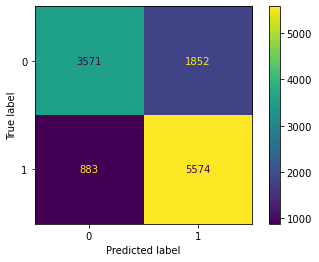

In [152]:
# Print model metrics
# Predict target
y_pred = log_model.predict(X_test)

# Create metrics object
score_metrics = Metrics()

# Print classification report, scores, and confusion matrix
score_metrics.model_score(log_model, y_test, y_pred)

baseline model pipeline